<a href="https://colab.research.google.com/github/doogzultz/time_series_project/blob/main/model_test_feature_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.plotting import scatter_matrix
from tensorflow.keras.layers import Layer, Dense, Dropout, Input, \
Flatten, Concatenate, Conv1D, LSTM, Bidirectional, BatchNormalization, Activation, TimeDistributed, Lambda, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

In [72]:
class g:
  window_size = 16
  batch_size = 16
  valid_size = .1
  test_size = .1
  test = False

In [73]:
url = "https://raw.githubusercontent.com/doogzultz/time_series_project/main/data.csv"
data = pd.read_csv(url)

In [74]:
data.columns

Index(['date', 'identifier', 'market_cap', 'sector', 'index_membership',
       'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
       'factor_7', 'factor_8', 'factor_9', 'factor_10', 'target'],
      dtype='object')

In [75]:
data.drop(columns = 'index_membership', inplace = True)

In [76]:
data.sort_values(by = ['identifier', 'date'], inplace = True)
data

,date,identifier,market_cap,sector,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,target
82,2010-01-06,AD41WBQFVG43,5.843968e+10,35,0.766639,-0.000032,0.832677,0.500608,0.193489,0.246089,0.753702,0.792736,-0.000005,0.109029,-0.000006
400,2010-01-13,AD41WBQFVG43,4.758865e+10,35,0.907349,-0.022933,0.346457,0.581694,0.648483,0.872304,0.723412,0.333230,-0.009504,0.121348,-0.008721
718,2010-01-20,AD41WBQFVG43,3.374757e+10,35,0.476465,-0.000114,0.592328,0.379747,0.810961,0.017737,0.619208,0.058918,-0.000099,0.890898,-0.000081
1036,2010-01-27,AD41WBQFVG43,4.908395e+10,35,0.265141,-0.000034,0.521405,0.682492,0.547349,0.155915,0.068966,0.699718,-0.000037,0.355059,-0.000018
1354,2010-02-03,AD41WBQFVG43,2.729189e+10,35,0.423987,0.000197,0.950500,0.628533,0.956287,0.426634,0.752799,0.961276,0.000163,0.196711,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12552,2010-10-06,ZMYXRS4KVOG2,6.504496e+08,25,0.069622,0.009936,0.588354,0.447469,0.353549,0.767779,0.790632,0.308049,0.012255,0.281193,0.005117
12862,2010-10-13,ZMYXRS4KVOG2,1.403710e+09,25,0.343444,0.002566,0.394802,0.143162,0.116762,0.744089,0.825323,0.559633,0.001058,0.755124,0.000446
13172,2010-10-20,ZMYXRS4KVOG2,7.284687e+08,25,0.857557,0.000146,0.892729,0.113346,0.574870,0.990100,0.319424,0.591153,0.000054,0.933679,0.000035
13483,2010-10-27,ZMYXRS4KVOG2,7.766592e+08,25,0.093894,-0.000885,0.311392,0.768537,0.589851,0.289180,0.431484,0.373209,-0.000411,0.225972,-0.000242


In [77]:
(data== 0).sum(axis=0)

date           0
identifier     0
market_cap     0
sector         0
factor_1       0
factor_2      68
factor_3       0
factor_4       0
factor_5       0
factor_6       0
factor_7       0
factor_8       0
factor_9      68
factor_10      0
target        68
dtype: int64

In [78]:
ident_counts= data.value_counts('identifier')
ident_counts

identifier
AD41WBQFVG43    104
UZ4DWDZ8ALZ4    104
KR47536Y10D4    104
KPJ8FTV9ESJ3    104
KMHQ727PU8E2    104
               ... 
PNUM57CYEB27      5
KHKNKSMXBWP3      5
LYCPQJ19AOY0      5
RENR64FT3I74      5
LALJLSN9UMP2      2
Length: 356, dtype: int64

In [79]:
data.value_counts('sector', normalize = True).sort_index()

sector
10    0.049221
15    0.093162
20    0.208527
25    0.132849
30    0.072759
35    0.049003
40    0.232812
45    0.051674
50    0.038352
55    0.071642
dtype: float64

In [80]:
data[data['identifier'].isin(list(ident_counts[ident_counts.values > 80].index))].value_counts('sector', normalize = True).sort_index()

sector
10    0.052423
15    0.093655
20    0.212044
25    0.126521
30    0.076618
35    0.045433
40    0.228443
45    0.052423
50    0.039048
55    0.073392
dtype: float64

In [81]:
data[data['identifier'].isin(list(ident_counts[ident_counts.values <= 80].index))].value_counts('sector', normalize = True).sort_index()

sector
10    0.010229
15    0.087152
20    0.165712
25    0.209902
30    0.025777
35    0.092471
40    0.286007
45    0.042553
50    0.029869
55    0.050327
dtype: float64

In [82]:
sector_onehot = pd.get_dummies(data['sector'], prefix='sector')
sector_onehot

,sector_10,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55
82,0,0,0,0,0,1,0,0,0,0
400,0,0,0,0,0,1,0,0,0,0
718,0,0,0,0,0,1,0,0,0,0
1036,0,0,0,0,0,1,0,0,0,0
1354,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
12552,0,0,0,1,0,0,0,0,0,0
12862,0,0,0,1,0,0,0,0,0,0
13172,0,0,0,1,0,0,0,0,0,0
13483,0,0,0,1,0,0,0,0,0,0


In [83]:
target = data['target']
data.drop(columns = ['sector', 'target'], inplace = True)
data = pd.concat([data, sector_onehot, target], axis = 1)
data

,date,identifier,market_cap,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target
82,2010-01-06,AD41WBQFVG43,5.843968e+10,0.766639,-0.000032,0.832677,0.500608,0.193489,0.246089,0.753702,...,0,0,0,0,1,0,0,0,0,-0.000006
400,2010-01-13,AD41WBQFVG43,4.758865e+10,0.907349,-0.022933,0.346457,0.581694,0.648483,0.872304,0.723412,...,0,0,0,0,1,0,0,0,0,-0.008721
718,2010-01-20,AD41WBQFVG43,3.374757e+10,0.476465,-0.000114,0.592328,0.379747,0.810961,0.017737,0.619208,...,0,0,0,0,1,0,0,0,0,-0.000081
1036,2010-01-27,AD41WBQFVG43,4.908395e+10,0.265141,-0.000034,0.521405,0.682492,0.547349,0.155915,0.068966,...,0,0,0,0,1,0,0,0,0,-0.000018
1354,2010-02-03,AD41WBQFVG43,2.729189e+10,0.423987,0.000197,0.950500,0.628533,0.956287,0.426634,0.752799,...,0,0,0,0,1,0,0,0,0,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12552,2010-10-06,ZMYXRS4KVOG2,6.504496e+08,0.069622,0.009936,0.588354,0.447469,0.353549,0.767779,0.790632,...,0,0,1,0,0,0,0,0,0,0.005117
12862,2010-10-13,ZMYXRS4KVOG2,1.403710e+09,0.343444,0.002566,0.394802,0.143162,0.116762,0.744089,0.825323,...,0,0,1,0,0,0,0,0,0,0.000446
13172,2010-10-20,ZMYXRS4KVOG2,7.284687e+08,0.857557,0.000146,0.892729,0.113346,0.574870,0.990100,0.319424,...,0,0,1,0,0,0,0,0,0,0.000035
13483,2010-10-27,ZMYXRS4KVOG2,7.766592e+08,0.093894,-0.000885,0.311392,0.768537,0.589851,0.289180,0.431484,...,0,0,1,0,0,0,0,0,0,-0.000242


In [84]:
import math
from math import floor as fl
ident_counts= data.value_counts('identifier')
def split_to_series(df, valid_size = g.valid_size, test_size = g.test_size,length_cutoff = 3*g.window_size, test = True):
  ident_counts= df.value_counts('identifier')
  df_long = df[df['identifier'].isin(list(ident_counts[ident_counts.values > length_cutoff].index))]
  df_short = df[df['identifier'].isin(list(ident_counts[(ident_counts.values <= length_cutoff) & (ident_counts.values >= 2*g.window_size)].index))]
  series_dict = {}
  train_dict = {}
  valid_dict = {}
  test_dict = {0: pd.DataFrame(columns = data.columns)}
  for i, ident in enumerate(df_long.value_counts('identifier').index):
    series_dict[i] = df_long[df_long['identifier'] == ident].sort_values('date').reset_index().drop(columns = 'index')
    if test == True:
      train_dict[i] = series_dict[i].iloc[:fl((1-valid_size - test_size)*len(series_dict[i])) - 2*g.window_size]
      valid_dict[i] = series_dict[i].iloc[fl((1-valid_size - test_size)*len(series_dict[i]))- 2*g.window_size:fl((1- test_size)*len(series_dict[i]))- g.window_size]
      test_dict[i] = series_dict[i].iloc[fl((1- test_size)*len(series_dict[i]))- g.window_size:]
    else:
      train_dict[i] = series_dict[i].iloc[:fl((1-valid_size)*len(series_dict[i])) - g.window_size]
      valid_dict[i] = series_dict[i].iloc[fl((1-valid_size)*len(series_dict[i]))- g.window_size:]
  for j, ident in enumerate(df_short.value_counts('identifier').index):
    train_dict[len(series_dict)+j] = df_short[df_short['identifier'] == ident].sort_values('date').reset_index().drop(columns = 'index')
  print(f"Number of time series to be trained and tested: {len([keys for keys in series_dict])}")
  print(f"Number of time series to be trained: {len([keys for keys in train_dict])}")
  return train_dict, valid_dict, test_dict

In [85]:
train_dict, valid_dict, test_dict = split_to_series(data, test = False)

Number of time series to be trained and tested: 310
Number of time series to be trained: 323


In [86]:
numerical_features = ['market_cap','factor_2','factor_9','target']
numerical_features

['market_cap', 'factor_2', 'factor_9', 'target']

In [87]:
test_dict[0]

,date,identifier,market_cap,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target


In [88]:
def preprocess(train_dict, valid_dict, test_dict, numerical_features):
  train_df = pd.concat(train_dict, ignore_index = True)
  t_mean = np.mean(train_df[numerical_features])
  t_std = np.std(train_df[numerical_features])
  for i in range(0,len(train_dict)):
    train_dict[i][numerical_features] = (train_dict[i][numerical_features]-t_mean)/t_std
    train_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
  for i in range(0,len(valid_dict)):
    valid_dict[i][numerical_features] = (valid_dict[i][numerical_features]-t_mean)/t_std
    valid_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
    try:
      test_dict[i][numerical_features] = (test_dict[i][numerical_features]-t_mean)/t_std
      test_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
    except KeyError:
      continue
  return train_dict, valid_dict, test_dict


In [89]:
train_scaled, valid_scaled, test_scaled = preprocess(train_dict, valid_dict, test_dict, numerical_features)

In [90]:
train_scaled[0]

,date,identifier,market_cap,factor_2,factor_9,sector_10,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target
0,2010-01-06,AD41WBQFVG43,2.887202,-0.036714,-0.026663,0,0,0,0,0,1,0,0,0,0,-0.028839
1,2010-01-13,AD41WBQFVG43,2.220417,-4.840372,-1.946794,0,0,0,0,0,1,0,0,0,0,-1.892817
2,2010-01-20,AD41WBQFVG43,1.369897,-0.053838,-0.045588,0,0,0,0,0,1,0,0,0,0,-0.044977
3,2010-01-27,AD41WBQFVG43,2.312302,-0.037079,-0.033006,0,0,0,0,0,1,0,0,0,0,-0.031399
4,2010-02-03,AD41WBQFVG43,0.973202,0.011314,0.007415,0,0,0,0,0,1,0,0,0,0,0.040418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2011-05-25,AD41WBQFVG43,1.809097,0.811867,0.142045,0,0,0,0,0,1,0,0,0,0,0.612629
73,2011-06-01,AD41WBQFVG43,1.649879,-0.198012,-0.117690,0,0,0,0,0,1,0,0,0,0,-0.491603
74,2011-06-08,AD41WBQFVG43,2.843232,0.003374,0.224744,0,0,0,0,0,1,0,0,0,0,0.122041
75,2011-06-15,AD41WBQFVG43,3.185297,-0.032241,-0.029172,0,0,0,0,0,1,0,0,0,0,-0.028973


In [91]:
valid_scaled[0]

,date,identifier,market_cap,factor_2,factor_9,sector_10,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target
77,2011-06-29,AD41WBQFVG43,2.975604,0.239620,0.187886,0,0,0,0,0,1,0,0,0,0,0.044625
78,2011-07-06,AD41WBQFVG43,3.441088,-0.048897,-0.102009,0,0,0,0,0,1,0,0,0,0,-0.758017
79,2011-07-13,AD41WBQFVG43,1.371523,-0.043166,-0.028723,0,0,0,0,0,1,0,0,0,0,-0.069778
80,2011-07-20,AD41WBQFVG43,2.113004,-1.118645,-3.692968,0,0,0,0,0,1,0,0,0,0,-1.666965
81,2011-07-27,AD41WBQFVG43,2.088300,-0.582714,-0.457238,0,0,0,0,0,1,0,0,0,0,-0.641416
82,2011-08-03,AD41WBQFVG43,2.273857,-0.079865,-0.063435,0,0,0,0,0,1,0,0,0,0,-0.134657
83,2011-08-10,AD41WBQFVG43,1.281153,-1.296414,-2.104729,0,0,0,0,0,1,0,0,0,0,-2.586506
84,2011-08-17,AD41WBQFVG43,2.245092,-1.438307,-1.649952,0,0,0,0,0,1,0,0,0,0,-1.581289
85,2011-08-24,AD41WBQFVG43,1.302458,-0.396185,-0.068665,0,0,0,0,0,1,0,0,0,0,-0.276009
86,2011-08-31,AD41WBQFVG43,2.698281,-0.154388,-0.082245,0,0,0,0,0,1,0,0,0,0,-0.138655


In [92]:
test_scaled[0]

,date,identifier,market_cap,factor_2,factor_9,sector_10,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target


In [93]:
train_scaled[0].columns

Index(['date', 'identifier', 'market_cap', 'factor_2', 'factor_9', 'sector_10',
       'sector_15', 'sector_20', 'sector_25', 'sector_30', 'sector_35',
       'sector_40', 'sector_45', 'sector_50', 'sector_55', 'target'],
      dtype='object')

In [94]:
train_scaled[322].columns

Index(['date', 'identifier', 'market_cap', 'factor_2', 'factor_9', 'sector_10',
       'sector_15', 'sector_20', 'sector_25', 'sector_30', 'sector_35',
       'sector_40', 'sector_45', 'sector_50', 'sector_55', 'target'],
      dtype='object')

In [95]:
def drop_final_columns(data_dict):
  for i in range(0, len(data_dict)):
    data_dict[i].drop(columns = ['date', 'identifier'], inplace = True)
  return data_dict

In [96]:
train_scaled, valid_scaled, test_scaled = \
drop_final_columns(train_scaled), drop_final_columns(valid_scaled), drop_final_columns(test_scaled)

In [97]:
# y = [y for x,y in list(dataset)]
# print(y)

In [98]:
# dataset = tf.data.Dataset.from_tensor_slices(np.asarray(valid_scaled[0]))
# dataset = dataset.window(g.window_size + 1, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(g.window_size + 1))
# dataset = dataset.map(lambda window: (window[:-1], window[-1,-1]))
# dataset = dataset.batch(8)
# x_batch, y_batch = iter(dataset).get_next()
# print(len(list(dataset)))
# print(y_batch)
# print(list(dataset))

In [99]:
def convert_to_tensor(data_dict, window_size = g.window_size, batch_size = g.batch_size, shuffle_buffer = 1000, shuffle = True):
    dataset = tf.data.Dataset.from_tensor_slices(np.asarray(data_dict[0]))
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1,-1]))
    for i in range(1, len(data_dict)):
      dataset_tmp = tf.data.Dataset.from_tensor_slices(np.asarray(data_dict[i]))
      dataset_tmp = dataset_tmp.window(window_size + 1, shift=1, drop_remainder=True)
      dataset_tmp = dataset_tmp.flat_map(lambda window: window.batch(window_size + 1))
      dataset_tmp = dataset_tmp.map(lambda window: (window[:-1], window[-1,-1]))
      dataset = dataset.concatenate(dataset_tmp)
    if shuffle == True:
      dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [100]:
train = convert_to_tensor(train_scaled)
valid = convert_to_tensor(valid_scaled, shuffle = False)
test = convert_to_tensor(test_scaled, shuffle = False)

In [101]:
import tensorflow.keras.backend as K

def smape_loss(y_true, y_pred):
    epsilon = 1e-4
    #summ = K.minimum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred) + epsilon) * 2.0
    return smape

In [102]:
def conv_block(input_,filter_units,kernel_size,dr):
    x = Conv1D(filters = filter_units/2, kernel_size = kernel_size, strides = 1,
                                                              kernel_initializer='he_normal', padding = 'causal',activation = 'relu')(input_)
    x = Dropout(dr)(x)
    x = MaxPooling1D()(x)
    x = Conv1D(filters = filter_units, kernel_size = kernel_size, strides = 1,
                                                              kernel_initializer='he_normal', padding = 'causal',activation = 'relu')(x)
    x = Dropout(dr)(x)
    out = MaxPooling1D()(x)
    return out

In [103]:
def lstm_block(input_,lstm_units, dr):
    x = LSTM(lstm_units, return_sequences = True, dropout = dr)(input_)
    out = LSTM(lstm_units, return_sequences = False, dropout = dr)(x)
    return(out)

In [104]:
def dense_block(input_, dense_units, dr):
    x = Dense(dense_units, kernel_initializer="he_normal", activation = 'relu')(input_)
    x = Dropout(dr)(x)
    x = Dense(dense_units, kernel_initializer="he_normal", activation = 'relu')(x)
    out = Dropout(dr)(x)
    return out

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 14)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 16, 16)       688         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 16, 16)       0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 8, 16)        0           ['dropout[0][0]']                
                                                                                              

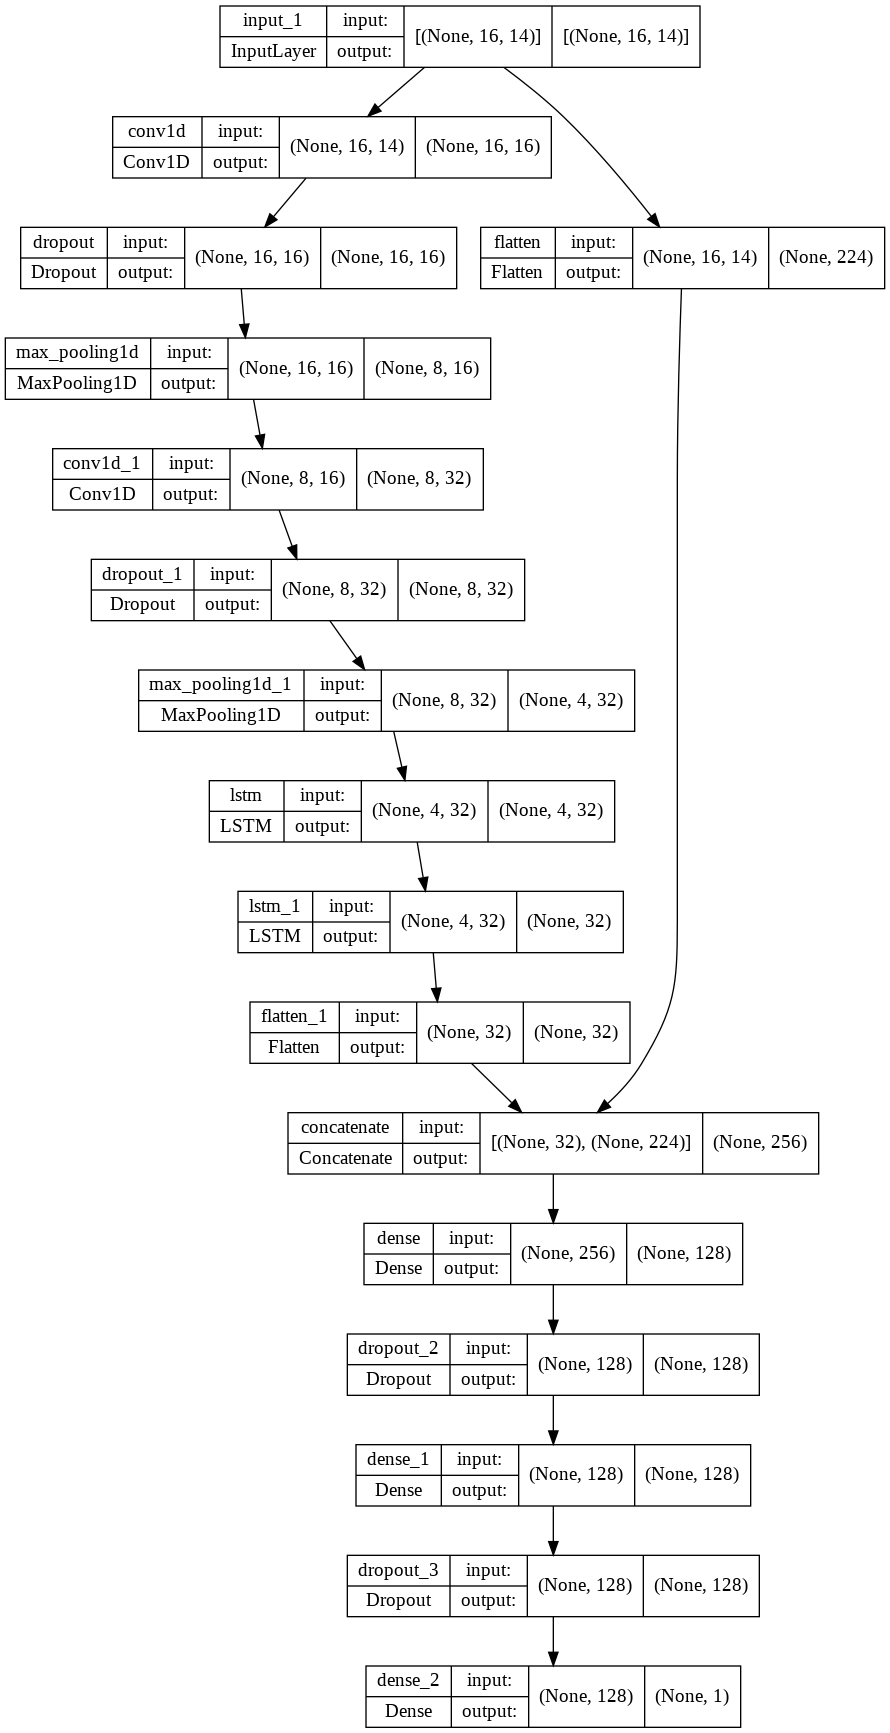

In [105]:
tf.keras.backend.clear_session()

def create_time_model(filter_units = 32, lstm_units = 32, kernel_size = 3, dense_units = 128, dr = .2 ):

    input_ = Input(shape=(g.window_size,14))
    y = Flatten()(input_)
    x = conv_block(input_,filter_units, kernel_size, dr)                                                            
    x = lstm_block(x, lstm_units, dr)
    x = Flatten()(x)
    x = Concatenate(axis=-1)([x, y])
    x = dense_block(x, dense_units, dr)
    out = Dense(1)(x)
    model = Model(inputs = input_, outputs = out)

    return model

model = create_time_model()
model.compile(loss = 'mape', optimizer = 'adam', metrics = ['mae', 'mape'])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [106]:
def plot_model_perf(history, metric = None):
  plt.subplots(len([metric]), 1, figsize=(12, 8))
  epochs = range(len(history.history['loss']))
  plt.plot( epochs, history.history['loss'],color = 'blue', label = 'loss' )
  plt.plot(epochs, history.history['val_loss'], color = 'red', label = 'val_loss' )
  plt.legend()
  plt.show()
  if metric:
    for i, metric in enumerate([metric]):
      plt.figure(figsize=(12, 8))
      plt.plot( epochs, history.history[f'{metric}'],color = 'green', label = f'{metric}' )
      plt.plot(epochs, history.history[f'val_{metric}'], color = 'orange', label = f'val_{metric}' )
      plt.legend()
      plt.show()

In [107]:
early_stopping = EarlyStopping(patience = 2, restore_best_weights= True)
history = model.fit(train, epochs = 20, validation_data = valid, callbacks = early_stopping)

Epoch 1/20
1142/1142 [==============================] - 64s 52ms/step - loss: 2297.6243 - mae: 0.6009 - mape: 2297.6243 - val_loss: 1121.2777 - val_mae: 0.6804 - val_mape: 1121.2777
Epoch 2/20
1142/1142 [==============================] - 65s 57ms/step - loss: 2400.2939 - mae: 0.5386 - mape: 2400.2939 - val_loss: 2366.9873 - val_mae: 0.6772 - val_mape: 2366.9873
Epoch 3/20
1142/1142 [==============================] - 72s 62ms/step - loss: 1732.1812 - mae: 0.4895 - mape: 1732.1812 - val_loss: 833.6286 - val_mae: 0.6339 - val_mape: 833.6286
Epoch 4/20
1142/1142 [==============================] - 69s 60ms/step - loss: 1201.2736 - mae: 0.4387 - mape: 1201.2736 - val_loss: 410.9596 - val_mae: 0.5696 - val_mape: 410.9596
Epoch 5/20
1142/1142 [==============================] - 66s 57ms/step - loss: 892.9850 - mae: 0.4123 - mape: 892.9850 - val_loss: 191.6140 - val_mae: 0.5422 - val_mape: 191.6140
Epoch 6/20
1140/1142 [============================>.] - ETA: 0s - loss: 483.6361 - mae: 0.3814 - m

KeyboardInterrupt: ignored

In [ ]:
plot_model_perf(history, 'mape')

In [ ]:
model.evaluate(valid)

In [131]:
def window_for_eval(data, window_size = g.window_size, batch_size = len(data)-g.batch_size+1):
  dataset = tf.data.Dataset.from_tensor_slices(np.asarray(data))
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1,-1]))
  dataset = dataset.batch(batch_size)
  return dataset


In [150]:
valid_window = window_for_eval(valid_scaled[0])
xbatch, ybatch = iter(valid_window).get_next()
test_pred = model.predict(valid_window)
vline = np.linspace(0, len(test_pred))
print(ybatch.numpy().reshape(-1))
print(test_pred.reshape(-1))

[ 3.32566468e-02 -3.58799077e-01  1.16137363e+00 -5.31185982e-04
 -2.18359062e-01 -5.02505386e-03 -2.83751575e-02 -2.15845917e-02
  8.84886219e-02  4.42786282e-01  2.53795711e-01]
[-0.01095495 -0.00151844  0.0130998   0.00582417  0.00496374  0.01229637
  0.0143711   0.00328118 -0.00246978 -0.00453958 -0.011236  ]


In [154]:
valid_scaled[0].columns.values

array(['market_cap', 'factor_2', 'factor_9', 'sector_10', 'sector_15',
       'sector_20', 'sector_25', 'sector_30', 'sector_35', 'sector_40',
       'sector_45', 'sector_50', 'sector_55', 'target'], dtype=object)

In [155]:
def plot_predictions(data, dict_number, model = model):
  plt.figure(figsize = (20, 8))
  test_batch = window_for_eval(data[dict_number])  
  xbatch, ybatch = iter(test_batch).get_next()
  test_pred = model.predict(test_batch)
  vline = np.linspace(0, test_pred.shape[0], test_pred.shape[0])
  plt.plot(vline, test_pred.reshape(-1), color = 'red', label = 'Prediction')
  plt.plot(vline, ybatch.numpy().reshape(-1), color = 'green', label = 'Actual')
  plt.title(f'Prediction vs. actual for validation dataset {dict_number}')
  plt.xlabel("Week")
  plt.ylabel("Value")
  plt.legend()
  plt.show()

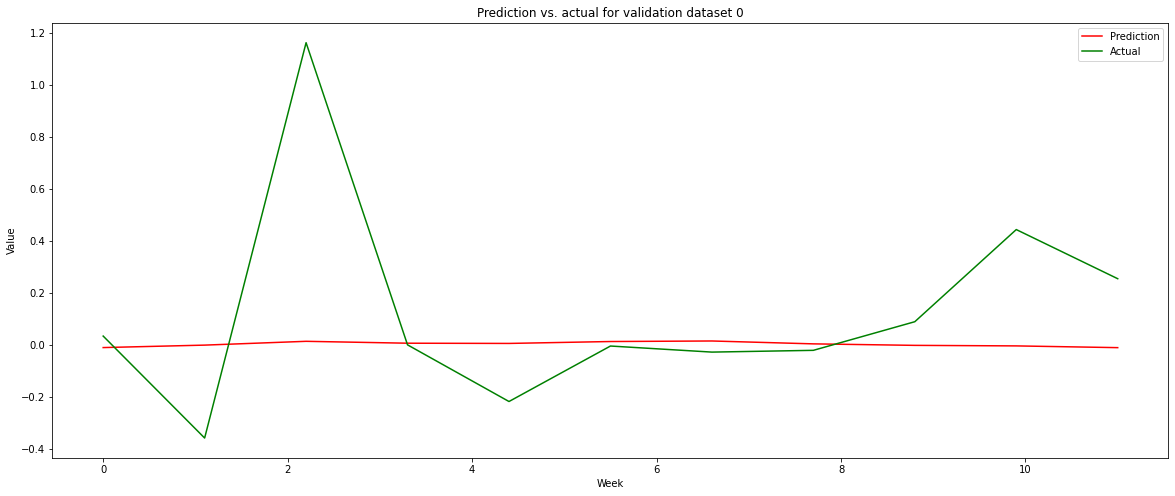

In [168]:
plot_predictions(valid_scaled, 0)